In [1]:
#!pip install -U --no-cache-dir gdown --pre

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread


In [3]:
# Download data of the imagenet-resnet152 model and the human readable labels for the imagenet dataset

if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz') 
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx'] # Softmax output of the model
labels = data['labels'].astype(int) # Real labels of the images


In [ ]:
n = 1000 # Number of calibration points
confiable_value = 0.75
alpha = 1 - confiable_value # 1-alpha is the desired coverage

Analyzing, I saw that with alpha until $0.25$ I get a good estimate

In [34]:
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]


# Conformal Predction

In [35]:
# 1: get conformal scores. n = calib_Y.shape[0]
cal_scores = 1-cal_smx[np.arange(n),cal_labels]
# 2: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, method='higher')
prediction_sets = val_smx >= (1-qhat) # 3: form prediction sets


In [36]:
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")


The empirical coverage is: 0.754938775510204


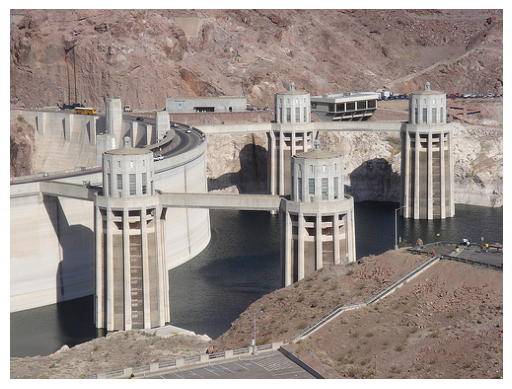

The prediction set is: ['dam']


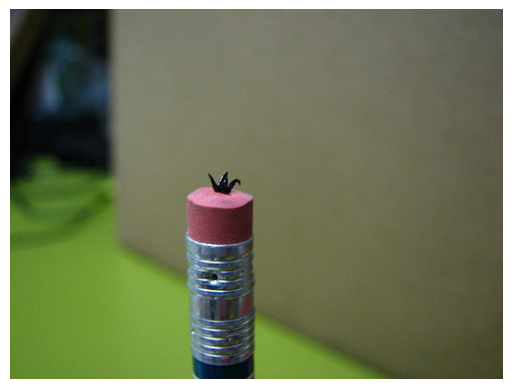

The prediction set is: ['eraser']


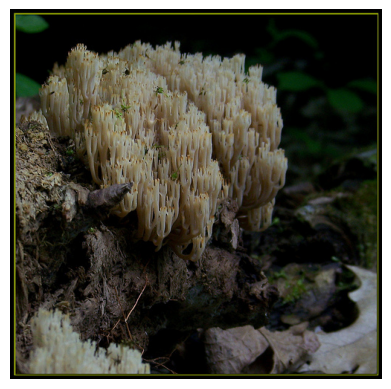

The prediction set is: ['coral fungus']


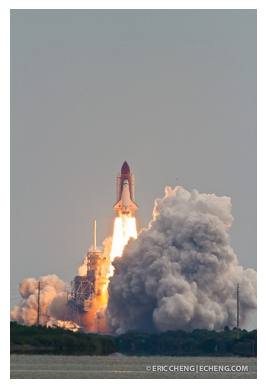

The prediction set is: ['space shuttle']


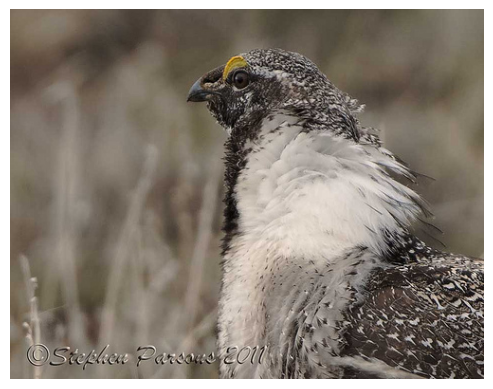

The prediction set is: ['ptarmigan']


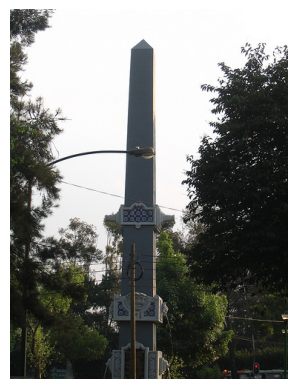

The prediction set is: ['obelisk']


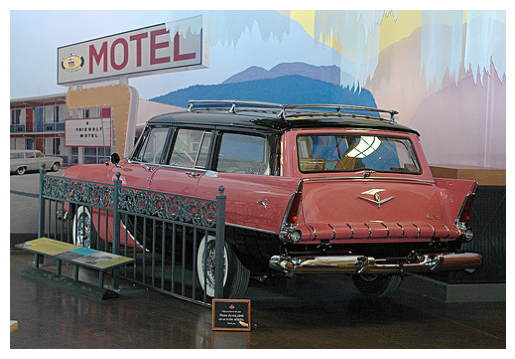

The prediction set is: ['station wagon']


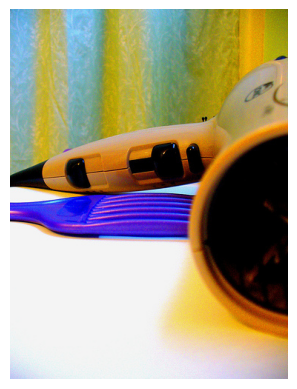

The prediction set is: ['hair dryer']


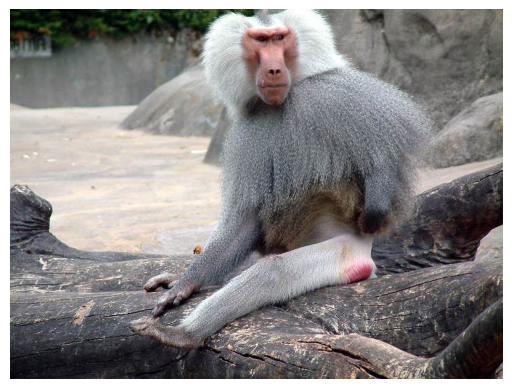

The prediction set is: ['baboon']


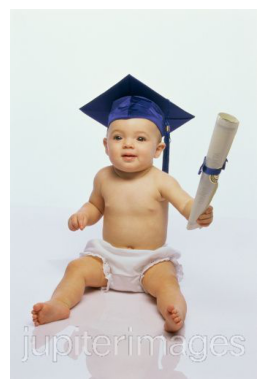

The prediction set is: ['square academic cap']


In [37]:
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")
